# Fine-tuned mBART Model Evaluation

This notebook evaluates the fine-tuned mBART-large-50 model on the CJEU legal translation test set.

**Evaluation Steps:**
1. Load fine-tuned model from Google Drive
2. Load test set (204 paragraph pairs)
3. Generate translations for all test examples
4. Calculate BLEU, chrF, and TER scores
5. Compare with baseline results
6. Analyze best improvements and worst cases
7. Evaluate legal term translation accuracy
8. Save comprehensive results

**Expected improvements:**
- BLEU increase of 5-15 points over baseline
- Better handling of legal terminology
- More consistent translation quality

In [14]:
# Install required packages (Colab only)
try:
    import google.colab
    print("Running in Colab - installing dependencies...")
    !pip install -q evaluate sacrebleu
    print("✓ Dependencies installed")
except ImportError:
    print("Not in Colab - skipping installation")

Running in Colab - installing dependencies...
✓ Dependencies installed


## 1. Setup and Imports

In [15]:
import os
import sys
import json
from pathlib import Path
from typing import Dict, List, Tuple
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import evaluate

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu128
CUDA available: True
CUDA device: NVIDIA A100-SXM4-40GB


## 2. Configure Paths

In [16]:
# Detect if running in Colab
try:
    import google.colab
    IN_COLAB = True
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    # Set paths for Colab
    PROJECT_ROOT = Path('/content/drive/MyDrive/french_german_translation')
    MODEL_PATH = PROJECT_ROOT / 'mbart-legal-fr-de'  # Fine-tuned model

except ImportError:
    IN_COLAB = False
    # Set paths for local environment
    PROJECT_ROOT = Path.cwd().parent
    MODEL_PATH = PROJECT_ROOT / 'checkpoints' / 'mbart-legal-fr-de'  # Fine-tuned model
    #MODEL_PATH = Path('/content/drive/MyDrive/mbart-legal-fr-de')

DATA_DIR = PROJECT_ROOT / 'data' / 'processed'
RESULTS_DIR = PROJECT_ROOT / 'results'
RESULTS_DIR.mkdir(exist_ok=True)

print(f"Running in Colab: {IN_COLAB}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Model path: {MODEL_PATH}")
print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running in Colab: True
Project root: /content/drive/MyDrive/french_german_translation
Model path: /content/drive/MyDrive/french_german_translation/mbart-legal-fr-de
Data directory: /content/drive/MyDrive/french_german_translation/data/processed
Results directory: /content/drive/MyDrive/french_german_translation/results


## 3. Load Fine-tuned Model

In [13]:
print("Loading fine-tuned mBART model...")
print(f"Model location: {MODEL_PATH}")

MODEL_PATH = Path('/content/drive/MyDrive/mbart-legal-fr-de')
# Check if model exists
if not MODEL_PATH.exists():
    raise FileNotFoundError(
        f"Fine-tuned model not found at {MODEL_PATH}.\n"
        "Please ensure training completed and model was saved."
    )

# Load tokenizer and model
tokenizer = MBart50TokenizerFast.from_pretrained(str(MODEL_PATH))
model = MBartForConditionalGeneration.from_pretrained(str(MODEL_PATH))

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"✓ Model loaded successfully")
print(f"  Device: {device}")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

Loading fine-tuned mBART model...
Model location: /content/drive/MyDrive/french_german_translation/mbart-legal-fr-de


Loading weights:   0%|          | 0/516 [00:00<?, ?it/s]

✓ Model loaded successfully
  Device: cuda
  Parameters: 610,879,488


## 4. Load Test Data

In [17]:
print("Loading test data...")

# Load parallel paragraphs
paragraphs_path = DATA_DIR / 'parallel_paragraphs.jsonl'
data = []
with open(paragraphs_path, 'r', encoding='utf-8') as f:
    for line in f:
        data.append(json.loads(line))

# Load split indices
splits_path = DATA_DIR / 'data_splits.json'
with open(splits_path, 'r', encoding='utf-8') as f:
    splits = json.load(f)

# Get test set
test_indices = splits['test_indices']
test_data = [data[i] for i in test_indices]

print(f"✓ Test set loaded: {len(test_data)} paragraph pairs")
print(f"\nExample test pair:")
print(f"  French: {test_data[0]['source_text'][:150]}...")
print(f"  German: {test_data[0]['target_text'][:150]}...")

Loading test data...
✓ Test set loaded: 204 paragraph pairs

Example test pair:
  French: La demande de décision préjudicielle porte sur l’interprétation de la notion de «fonctionnaires et [de] personnel assimilé», au sens de l’article 13, ...
  German: Das Vorabentscheidungsersuchen betrifft die Auslegung des Ausdrucks „Beamte und ihnen gleichgestellte Personen“ im Sinne von Art. 13 Abs. 2 Buchst. d ...


## 5. Generate Translations

In [18]:
def translate_batch(
    texts: List[str],
    model,
    tokenizer,
    device,
    src_lang: str = "fr_XX",
    tgt_lang: str = "de_DE",
    max_length: int = 512,
    num_beams: int = 5,
    batch_size: int = 8,
) -> List[str]:
    """Translate a batch of texts using the fine-tuned model.

    Args:
        texts: List of source texts to translate
        model: Fine-tuned translation model
        tokenizer: Model tokenizer
        device: Device to run on (cuda/cpu)
        src_lang: Source language code
        tgt_lang: Target language code
        max_length: Maximum sequence length
        num_beams: Number of beams for beam search
        batch_size: Batch size for translation

    Returns:
        List of translated texts
    """
    translations = []

    # Set source language
    tokenizer.src_lang = src_lang

    # Process in batches
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]

        # Tokenize
        inputs = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Generate
        with torch.no_grad():
            generated_tokens = model.generate(
                **inputs,
                forced_bos_token_id=tokenizer.lang_code_to_id[tgt_lang],
                max_length=max_length,
                num_beams=num_beams,
                early_stopping=True,
            )

        # Decode
        batch_translations = tokenizer.batch_decode(
            generated_tokens,
            skip_special_tokens=True
        )
        translations.extend(batch_translations)

    return translations


print("Generating translations for test set...")
print(f"Test set size: {len(test_data)} paragraphs")
print(f"Using device: {device}")
print(f"Batch size: 8 (adjust based on GPU memory)")

source_texts = [item['source_text'] for item in test_data]
reference_texts = [item['target_text'] for item in test_data]

# Generate translations with progress bar
predictions = []
batch_size = 8 if torch.cuda.is_available() else 4

for i in tqdm(range(0, len(source_texts), batch_size), desc="Translating"):
    batch = source_texts[i:i + batch_size]
    batch_preds = translate_batch(
        batch,
        model,
        tokenizer,
        device,
        batch_size=len(batch)
    )
    predictions.extend(batch_preds)

print(f"\n✓ Generated {len(predictions)} translations")
print(f"\nExample translation:")
print(f"  Source: {source_texts[0][:150]}...")
print(f"  Reference: {reference_texts[0][:150]}...")
print(f"  Prediction: {predictions[0][:150]}...")

Generating translations for test set...
Test set size: 204 paragraphs
Using device: cuda
Batch size: 8 (adjust based on GPU memory)


Translating:   0%|          | 0/26 [00:00<?, ?it/s]


✓ Generated 204 translations

Example translation:
  Source: La demande de décision préjudicielle porte sur l’interprétation de la notion de «fonctionnaires et [de] personnel assimilé», au sens de l’article 13, ...
  Reference: Das Vorabentscheidungsersuchen betrifft die Auslegung des Ausdrucks „Beamte und ihnen gleichgestellte Personen“ im Sinne von Art. 13 Abs. 2 Buchst. d ...
  Prediction: Das Vorabentscheidungsersuchen betrifft die Auslegung des Ausdrucks „Beamte und ihnen gleichgestellte Personen“ im Sinne von Art. 13 Abs. 2 Buchst. d ...


## 6. Calculate Metrics

In [19]:
print("Calculating evaluation metrics...")

# Load metrics
bleu_metric = evaluate.load("sacrebleu")
chrf_metric = evaluate.load("chrf")
ter_metric = evaluate.load("ter")

# Calculate corpus-level metrics
references_for_bleu = [[ref] for ref in reference_texts]  # BLEU expects list of references

bleu_result = bleu_metric.compute(
    predictions=predictions,
    references=references_for_bleu
)

chrf_result = chrf_metric.compute(
    predictions=predictions,
    references=reference_texts
)

ter_result = ter_metric.compute(
    predictions=predictions,
    references=reference_texts
)

finetuned_results = {
    "model": "mbart-large-50-finetuned",
    "test_size": len(test_data),
    "bleu": bleu_result["score"],
    "chrf": chrf_result["score"],
    "ter": ter_result["score"],
    "date": datetime.now().isoformat(),
}

print("\n" + "="*60)
print("FINE-TUNED MODEL RESULTS")
print("="*60)
print(f"BLEU:  {finetuned_results['bleu']:.2f}")
print(f"chrF:  {finetuned_results['chrf']:.2f}")
print(f"TER:   {finetuned_results['ter']:.2f}")
print("="*60)

Calculating evaluation metrics...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(



FINE-TUNED MODEL RESULTS
BLEU:  89.00
chrF:  94.28
TER:   8.92


## 7. Calculate Per-Example Metrics

In [20]:
print("Calculating per-example metrics...")

# Calculate sentence-level BLEU scores
from sacrebleu.metrics import BLEU
bleu_scorer = BLEU()

per_example_scores = []
for i, (pred, ref) in enumerate(zip(predictions, reference_texts)):
    # Sentence-level BLEU
    sent_bleu = bleu_scorer.sentence_score(pred, [ref]).score

    per_example_scores.append({
        "index": i,
        "id": test_data[i]['id'],
        "celex_id": test_data[i]['celex_id'],
        "source": source_texts[i],
        "reference": ref,
        "prediction": pred,
        "bleu": sent_bleu,
        "source_length": len(source_texts[i].split()),
        "ref_length": len(ref.split()),
        "pred_length": len(pred.split()),
    })

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(per_example_scores)

print(f"✓ Calculated metrics for {len(results_df)} examples")
print(f"\nBLEU score distribution:")
print(results_df['bleu'].describe())

Calculating per-example metrics...


✓ Calculated metrics for 204 examples

BLEU score distribution:
count    204.000000
mean      91.937572
std       12.167370
min       29.547963
25%       88.788162
50%       97.071899
75%      100.000000
max      100.000000
Name: bleu, dtype: float64


## 8. Load and Compare with Baseline


COMPARISON: BASELINE vs FINE-TUNED
Metric     Baseline     Fine-tuned   Improvement 
------------------------------------------------------------
BLEU            55.51       89.00  +     33.49
CHRF            72.23       94.28  +     22.05
TER             69.64        8.92  -     60.73

BLEU relative improvement: +60.3%


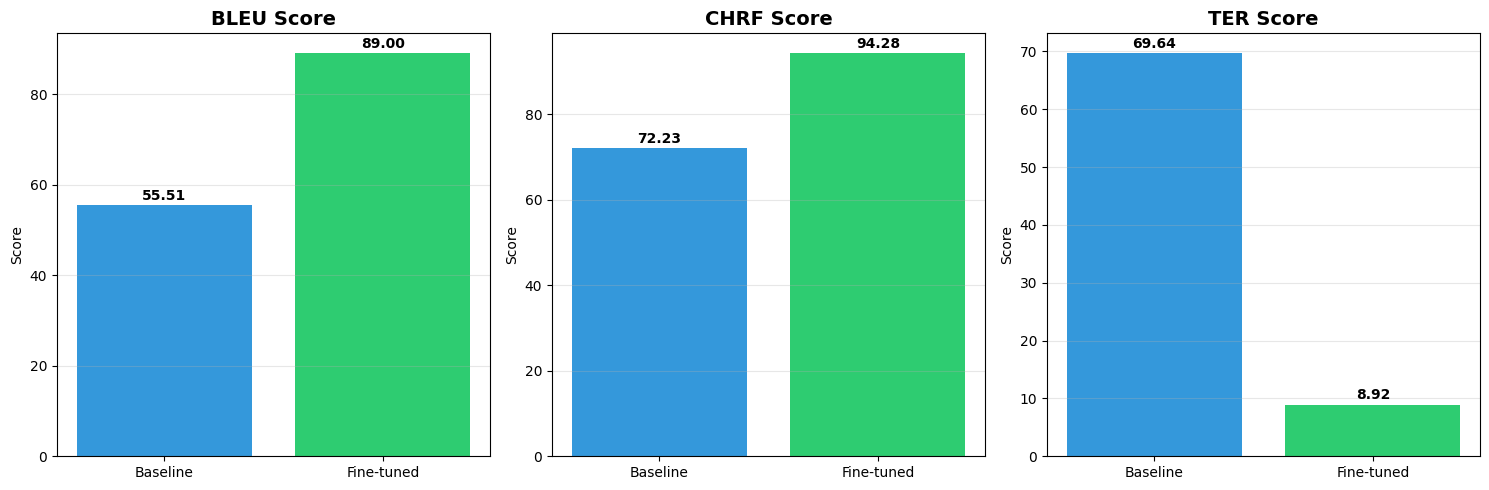


✓ Comparison plot saved to: /content/drive/MyDrive/french_german_translation/results/finetuned_vs_baseline.png


In [22]:
# Load baseline results
baseline_results_path = RESULTS_DIR / 'baseline_evaluation.json'

if baseline_results_path.exists():
    with open(baseline_results_path, 'r', encoding='utf-8') as f:
        baseline_data = json.load(f)

    baseline_results = baseline_data['metrics']

    print("\n" + "="*60)
    print("COMPARISON: BASELINE vs FINE-TUNED")
    print("="*60)
    print(f"{'Metric':<10} {'Baseline':<12} {'Fine-tuned':<12} {'Improvement':<12}")
    print("-" * 60)

    for metric in ['bleu', 'chrf', 'ter']:
        baseline_val = baseline_results[metric]
        finetuned_val = finetuned_results[metric]

        # For TER, lower is better
        if metric == 'ter':
            improvement = baseline_val - finetuned_val
            sign = "-" if improvement > 0 else "+"
        else:
            improvement = finetuned_val - baseline_val
            sign = "+" if improvement > 0 else ""

        print(f"{metric.upper():<10} {baseline_val:>10.2f}  {finetuned_val:>10.2f}  {sign}{improvement:>10.2f}")

    print("="*60)

    # Calculate relative improvements
    bleu_improvement_pct = ((finetuned_results['bleu'] - baseline_results['bleu']) / baseline_results['bleu']) * 100
    print(f"\nBLEU relative improvement: {bleu_improvement_pct:+.1f}%")

    # Visualization
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    metrics_to_plot = ['bleu', 'chrf', 'ter']
    for idx, metric in enumerate(metrics_to_plot):
        baseline_val = baseline_results[metric]
        finetuned_val = finetuned_results[metric]

        ax[idx].bar(['Baseline', 'Fine-tuned'], [baseline_val, finetuned_val],
                   color=['#3498db', '#2ecc71'])
        ax[idx].set_title(f"{metric.upper()} Score", fontsize=14, fontweight='bold')
        ax[idx].set_ylabel('Score')
        ax[idx].grid(axis='y', alpha=0.3)

        # Add value labels
        for i, v in enumerate([baseline_val, finetuned_val]):
            ax[idx].text(i, v + 0.5, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'finetuned_vs_baseline.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Comparison plot saved to: {RESULTS_DIR / 'finetuned_vs_baseline.png'}")

else:
    print("⚠ Baseline results not found. Cannot compare.")
    print(f"  Expected at: {baseline_results_path}")
    baseline_results = None

## 9. Best Improvements Analysis

In [23]:
# Sort by BLEU score
results_sorted = results_df.sort_values('bleu', ascending=False)

print("\n" + "="*80)
print("TOP 10 BEST TRANSLATIONS (Highest BLEU)")
print("="*80)

for i, row in results_sorted.head(10).iterrows():
    print(f"\n#{row.name + 1} - BLEU: {row['bleu']:.2f} - ID: {row['id']}")
    print("-" * 80)
    print(f"Source (FR):     {row['source'][:200]}..." if len(row['source']) > 200 else f"Source (FR):     {row['source']}")
    print(f"Reference (DE):  {row['reference'][:200]}..." if len(row['reference']) > 200 else f"Reference (DE):  {row['reference']}")
    print(f"Prediction (DE): {row['prediction'][:200]}..." if len(row['prediction']) > 200 else f"Prediction (DE): {row['prediction']}")


TOP 10 BEST TRANSLATIONS (Highest BLEU)

#1 - BLEU: 100.00 - ID: 62009CJ0296_para0001
--------------------------------------------------------------------------------
Source (FR):     La demande de décision préjudicielle porte sur l’interprétation de la notion de «fonctionnaires et [de] personnel assimilé», au sens de l’article 13, paragraphe 2, sous d), du règlement (CEE) n° 1408/...
Reference (DE):  Das Vorabentscheidungsersuchen betrifft die Auslegung des Ausdrucks „Beamte und ihnen gleichgestellte Personen“ im Sinne von Art. 13 Abs. 2 Buchst. d der Verordnung (EWG) Nr. 1408/71 des Rates vom 14....
Prediction (DE): Das Vorabentscheidungsersuchen betrifft die Auslegung des Ausdrucks „Beamte und ihnen gleichgestellte Personen“ im Sinne von Art. 13 Abs. 2 Buchst. d der Verordnung (EWG) Nr. 1408/71 des Rates vom 14....

#2 - BLEU: 100.00 - ID: 62009CJ0296_para0002
--------------------------------------------------------------------------------
Source (FR):     Cette demande a été prése

## 10. Worst Cases Analysis

In [24]:
print("\n" + "="*80)
print("TOP 10 WORST TRANSLATIONS (Lowest BLEU)")
print("="*80)

for i, row in results_sorted.tail(10).iterrows():
    print(f"\n#{row.name + 1} - BLEU: {row['bleu']:.2f} - ID: {row['id']}")
    print("-" * 80)
    print(f"Source (FR):     {row['source'][:200]}..." if len(row['source']) > 200 else f"Source (FR):     {row['source']}")
    print(f"Reference (DE):  {row['reference'][:200]}..." if len(row['reference']) > 200 else f"Reference (DE):  {row['reference']}")
    print(f"Prediction (DE): {row['prediction'][:200]}..." if len(row['prediction']) > 200 else f"Prediction (DE): {row['prediction']}")
    print(f"\nIssues detected:")
    if row['pred_length'] < row['ref_length'] * 0.5:
        print("  - Prediction too short")
    elif row['pred_length'] > row['ref_length'] * 1.5:
        print("  - Prediction too long")
    if row['bleu'] < 10:
        print("  - Very low BLEU score (possible mistranslation)")


TOP 10 WORST TRANSLATIONS (Lowest BLEU)

#178 - BLEU: 66.52 - ID: 62014CJ0573_para0037
--------------------------------------------------------------------------------
Source (FR):     Estimant, dès lors, qu’aucun des agissements pour lesquels M. Lounani avait été condamné n’atteignait le degré de gravité requis pour être qualifié d’“agissements contraires aux buts et aux principes ...
Reference (DE):  Da der Conseil du contentieux des étrangers (Rat für Ausländerstreitsachen) folglich der Ansicht war, dass keine der Handlungen, wegen deren Herr Lounani verurteilt worden war, die erforderliche Schwe...
Prediction (DE): Da der Conseil du contentieux des étrangers (Rat für Ausländerstreitsachen) folglich der Ansicht war, dass keine der Handlungen, wegen deren Herr Lounani verurteilt worden war, die erforderliche Schwe...

Issues detected:

#63 - BLEU: 66.11 - ID: 62009CJ0065_para0031
--------------------------------------------------------------------------------
Source (FR):     S’agis

## 11. Legal Term Translation Accuracy

In [25]:
# Define key legal terms to track (French -> German)
legal_terms = {
    # French term: Expected German translation(s)
    "question préjudicielle": ["Vorabentscheidungsersuchen", "Vorabentscheidung"],
    "Cour de justice": ["Gerichtshof"],
    "directive": ["Richtlinie"],
    "règlement": ["Verordnung"],
    "traité": ["Vertrag"],
    "juridiction nationale": ["einzelstaatliches Gericht", "nationale Gericht"],
    "droit de l'Union": ["Unionsrecht", "Recht der Union"],
    "État membre": ["Mitgliedstaat"],
    "dispositions": ["Bestimmungen"],
    "interprétation": ["Auslegung"],
}

print("Analyzing legal term translation accuracy...")
print("\nKey Legal Terms Tracking:")
print("="*80)

term_accuracy = {}
for fr_term, de_terms in legal_terms.items():
    occurrences = 0
    correct_translations = 0

    for idx, row in results_df.iterrows():
        # Check if French term appears in source
        if fr_term.lower() in row['source'].lower():
            occurrences += 1

            # Check if any expected German term appears in prediction
            pred_lower = row['prediction'].lower()
            if any(de_term.lower() in pred_lower for de_term in de_terms):
                correct_translations += 1

    if occurrences > 0:
        accuracy = (correct_translations / occurrences) * 100
        term_accuracy[fr_term] = {
            "occurrences": occurrences,
            "correct": correct_translations,
            "accuracy": accuracy
        }

        print(f"\n{fr_term:30} → {', '.join(de_terms)}")
        print(f"  Occurrences: {occurrences:3d}  |  Correct: {correct_translations:3d}  |  Accuracy: {accuracy:5.1f}%")

# Calculate overall legal term accuracy
if term_accuracy:
    overall_accuracy = sum(t['accuracy'] for t in term_accuracy.values()) / len(term_accuracy)
    print("\n" + "="*80)
    print(f"Overall Legal Term Translation Accuracy: {overall_accuracy:.1f}%")
    print("="*80)
else:
    print("\n⚠ No legal terms found in test set")
    overall_accuracy = None

Analyzing legal term translation accuracy...

Key Legal Terms Tracking:

question préjudicielle         → Vorabentscheidungsersuchen, Vorabentscheidung
  Occurrences:   2  |  Correct:   1  |  Accuracy:  50.0%

directive                      → Richtlinie
  Occurrences:  80  |  Correct:  80  |  Accuracy: 100.0%

règlement                      → Verordnung
  Occurrences:  21  |  Correct:  20  |  Accuracy:  95.2%

traité                         → Vertrag
  Occurrences:   2  |  Correct:   0  |  Accuracy:   0.0%

juridiction nationale          → einzelstaatliches Gericht, nationale Gericht
  Occurrences:   2  |  Correct:   0  |  Accuracy:   0.0%

État membre                    → Mitgliedstaat
  Occurrences:   9  |  Correct:   9  |  Accuracy: 100.0%

dispositions                   → Bestimmungen
  Occurrences:  12  |  Correct:   9  |  Accuracy:  75.0%

interprétation                 → Auslegung
  Occurrences:  18  |  Correct:  16  |  Accuracy:  88.9%

Overall Legal Term Translation Accuracy: 

## 12. BLEU Score Distribution

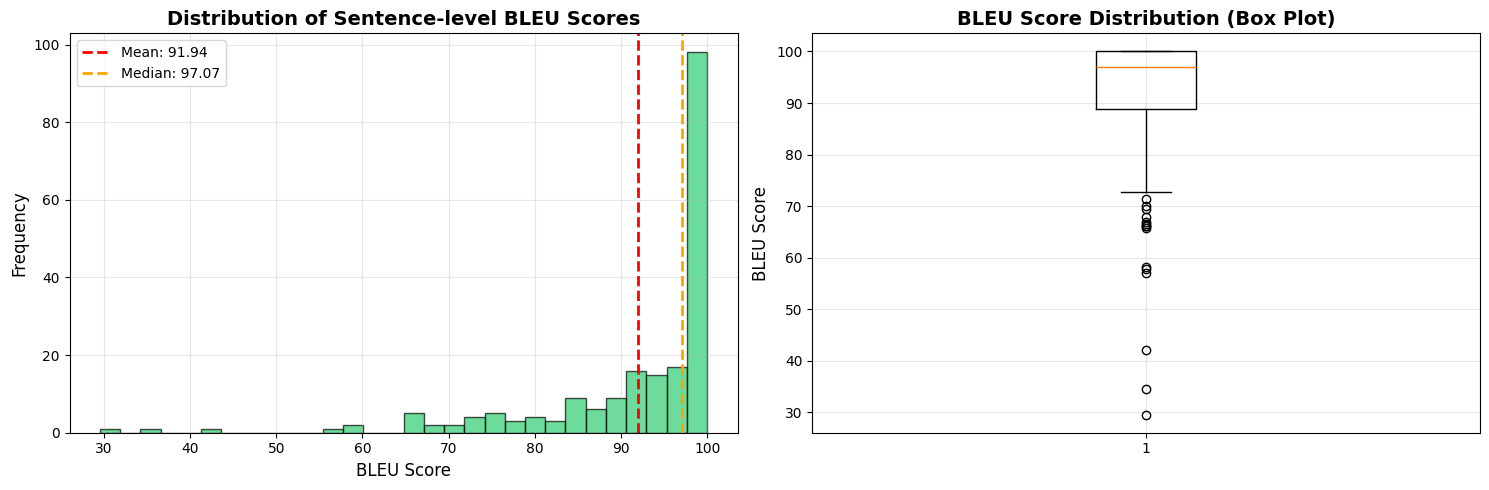

✓ BLEU distribution plot saved to: /content/drive/MyDrive/french_german_translation/results/bleu_distribution.png


In [26]:
# Visualize BLEU score distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(results_df['bleu'], bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[0].axvline(results_df['bleu'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {results_df["bleu"].mean():.2f}')
axes[0].axvline(results_df['bleu'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {results_df["bleu"].median():.2f}')
axes[0].set_xlabel('BLEU Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Sentence-level BLEU Scores', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(results_df['bleu'], vert=True)
axes[1].set_ylabel('BLEU Score', fontsize=12)
axes[1].set_title('BLEU Score Distribution (Box Plot)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'bleu_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ BLEU distribution plot saved to: {RESULTS_DIR / 'bleu_distribution.png'}")

## 13. Length Analysis

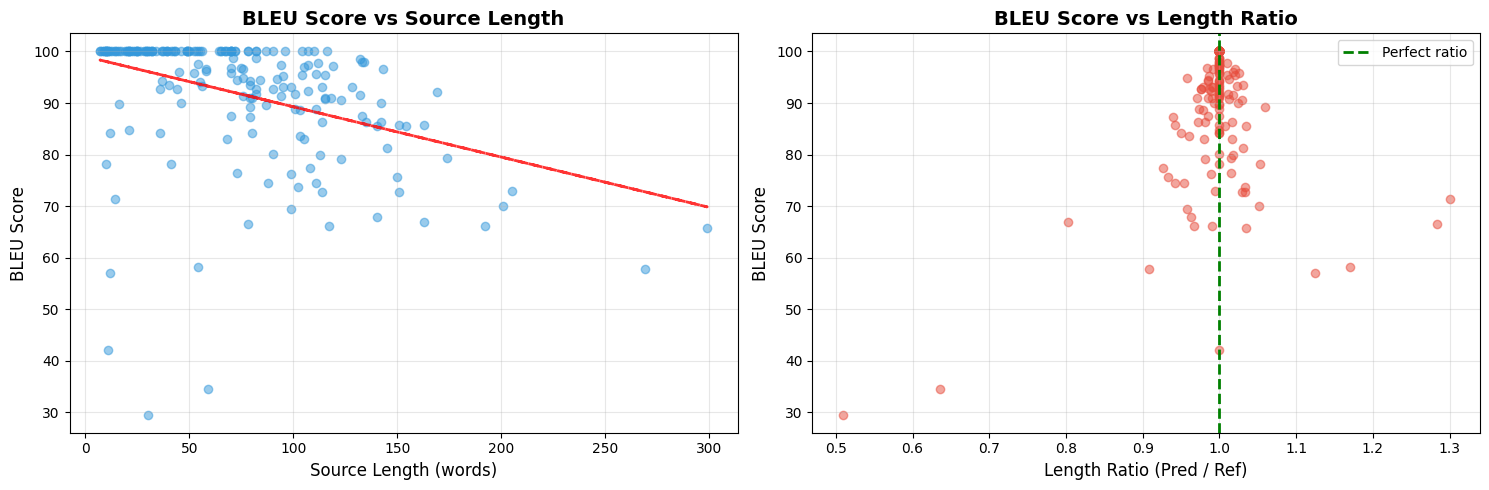

✓ Length analysis plot saved to: /content/drive/MyDrive/french_german_translation/results/length_analysis.png


In [27]:
# Analyze relationship between length and BLEU
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# BLEU vs source length
axes[0].scatter(results_df['source_length'], results_df['bleu'], alpha=0.5, color='#3498db')
axes[0].set_xlabel('Source Length (words)', fontsize=12)
axes[0].set_ylabel('BLEU Score', fontsize=12)
axes[0].set_title('BLEU Score vs Source Length', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Add trend line
z = np.polyfit(results_df['source_length'], results_df['bleu'], 1)
p = np.poly1d(z)
axes[0].plot(results_df['source_length'], p(results_df['source_length']), "r--", alpha=0.8, linewidth=2)

# Length ratio vs BLEU
results_df['length_ratio'] = results_df['pred_length'] / results_df['ref_length']
axes[1].scatter(results_df['length_ratio'], results_df['bleu'], alpha=0.5, color='#e74c3c')
axes[1].axvline(1.0, color='green', linestyle='--', linewidth=2, label='Perfect ratio')
axes[1].set_xlabel('Length Ratio (Pred / Ref)', fontsize=12)
axes[1].set_ylabel('BLEU Score', fontsize=12)
axes[1].set_title('BLEU Score vs Length Ratio', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Length analysis plot saved to: {RESULTS_DIR / 'length_analysis.png'}")

## 14. Save Complete Results

In [28]:
# Prepare complete results dictionary
complete_results = {
    "model_info": {
        "model_name": "mbart-large-50-finetuned",
        "model_path": str(MODEL_PATH),
        "training_date": "See trainer_state.json",
        "evaluation_date": datetime.now().isoformat(),
    },
    "corpus_metrics": finetuned_results,
    "per_example_stats": {
        "mean_bleu": float(results_df['bleu'].mean()),
        "median_bleu": float(results_df['bleu'].median()),
        "std_bleu": float(results_df['bleu'].std()),
        "min_bleu": float(results_df['bleu'].min()),
        "max_bleu": float(results_df['bleu'].max()),
    },
    "legal_term_accuracy": term_accuracy if term_accuracy else {},
    "overall_legal_term_accuracy": overall_accuracy,
}

# Add baseline comparison if available
if baseline_results:
    complete_results["baseline_comparison"] = {
        "baseline_bleu": baseline_results['bleu'],
        "finetuned_bleu": finetuned_results['bleu'],
        "bleu_improvement": finetuned_results['bleu'] - baseline_results['bleu'],
        "bleu_improvement_pct": ((finetuned_results['bleu'] - baseline_results['bleu']) / baseline_results['bleu']) * 100,
        "baseline_chrf": baseline_results['chrf'],
        "finetuned_chrf": finetuned_results['chrf'],
        "chrf_improvement": finetuned_results['chrf'] - baseline_results['chrf'],
        "baseline_ter": baseline_results['ter'],
        "finetuned_ter": finetuned_results['ter'],
        "ter_improvement": baseline_results['ter'] - finetuned_results['ter'],  # Lower is better
    }

# Save main results
results_file = RESULTS_DIR / 'finetuned_evaluation.json'
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(complete_results, f, indent=2, ensure_ascii=False)

print(f"\n✓ Main results saved to: {results_file}")

# Save detailed per-example results
detailed_file = RESULTS_DIR / 'finetuned_detailed_results.csv'
results_df.to_csv(detailed_file, index=False, encoding='utf-8')
print(f"✓ Detailed results saved to: {detailed_file}")

# Save best and worst examples
best_examples = results_sorted.head(10)[['id', 'bleu', 'source', 'reference', 'prediction']].to_dict('records')
worst_examples = results_sorted.tail(10)[['id', 'bleu', 'source', 'reference', 'prediction']].to_dict('records')

examples_file = RESULTS_DIR / 'finetuned_examples.json'
with open(examples_file, 'w', encoding='utf-8') as f:
    json.dump({
        "best_translations": best_examples,
        "worst_translations": worst_examples,
    }, f, indent=2, ensure_ascii=False)

print(f"✓ Best/worst examples saved to: {examples_file}")


✓ Main results saved to: /content/drive/MyDrive/french_german_translation/results/finetuned_evaluation.json
✓ Detailed results saved to: /content/drive/MyDrive/french_german_translation/results/finetuned_detailed_results.csv
✓ Best/worst examples saved to: /content/drive/MyDrive/french_german_translation/results/finetuned_examples.json


## 15. Summary Report

In [29]:
print("\n" + "="*80)
print("EVALUATION SUMMARY")
print("="*80)
print(f"\nModel: {complete_results['model_info']['model_name']}")
print(f"Test set size: {len(test_data)} paragraph pairs")
print(f"\nCorpus-level Metrics:")
print(f"  BLEU:  {finetuned_results['bleu']:.2f}")
print(f"  chrF:  {finetuned_results['chrf']:.2f}")
print(f"  TER:   {finetuned_results['ter']:.2f}")

if baseline_results:
    print(f"\nComparison with Baseline:")
    comp = complete_results['baseline_comparison']
    print(f"  BLEU improvement: {comp['bleu_improvement']:+.2f} ({comp['bleu_improvement_pct']:+.1f}%)")
    print(f"  chrF improvement: {comp['chrf_improvement']:+.2f}")
    print(f"  TER improvement:  {comp['ter_improvement']:+.2f} (lower is better)")

if overall_accuracy:
    print(f"\nLegal Term Translation Accuracy: {overall_accuracy:.1f}%")

print(f"\nPer-Example Statistics:")
stats = complete_results['per_example_stats']
print(f"  Mean BLEU:   {stats['mean_bleu']:.2f}")
print(f"  Median BLEU: {stats['median_bleu']:.2f}")
print(f"  Std Dev:     {stats['std_bleu']:.2f}")
print(f"  Range:       {stats['min_bleu']:.2f} - {stats['max_bleu']:.2f}")

print(f"\nOutput Files:")
print(f"  - {results_file}")
print(f"  - {detailed_file}")
print(f"  - {examples_file}")
print(f"  - {RESULTS_DIR / 'finetuned_vs_baseline.png'}")
print(f"  - {RESULTS_DIR / 'bleu_distribution.png'}")
print(f"  - {RESULTS_DIR / 'length_analysis.png'}")

print("\n" + "="*80)
print("EVALUATION COMPLETE ✅")
print("="*80)


EVALUATION SUMMARY

Model: mbart-large-50-finetuned
Test set size: 204 paragraph pairs

Corpus-level Metrics:
  BLEU:  89.00
  chrF:  94.28
  TER:   8.92

Comparison with Baseline:
  BLEU improvement: +33.49 (+60.3%)
  chrF improvement: +22.05
  TER improvement:  +60.73 (lower is better)

Legal Term Translation Accuracy: 63.6%

Per-Example Statistics:
  Mean BLEU:   91.94
  Median BLEU: 97.07
  Std Dev:     12.17
  Range:       29.55 - 100.00

Output Files:
  - /content/drive/MyDrive/french_german_translation/results/finetuned_evaluation.json
  - /content/drive/MyDrive/french_german_translation/results/finetuned_detailed_results.csv
  - /content/drive/MyDrive/french_german_translation/results/finetuned_examples.json
  - /content/drive/MyDrive/french_german_translation/results/finetuned_vs_baseline.png
  - /content/drive/MyDrive/french_german_translation/results/bleu_distribution.png
  - /content/drive/MyDrive/french_german_translation/results/length_analysis.png

EVALUATION COMPLETE ✅